- Preprocess
    - L - Rework loyalty_score calculation
    - Check total original rows vs rows after RFM to ensure the Customer IDs are reflected once to cover their entire lifetime as customers
    - AQC - Average Quantity calculation
    - Create separate df with customer ids and the RFM segment labels
    - CLV - customer lifetime value

- Clustering (without RFM labels)
    - Columns to cluster: *`R`,`F`,`M`,`L`,`AQC`,`CLV`*
    - Include loyalty_score and average quantity
    - For KMeans add - Silhouette scores, Calinski, Davis Bouldin
    - Agglomerative Clustering
    - *After clustering attempt cohort analysis per cluster*

- Presentation - Business case focussed
    - Case introduction
    - Workflow:
        - RFM Analysis
        - KMeans
        - Agglomerative
    - Description of the segments
    - Recommendations of campaigns for each segment
    - Further work:
        - Prediction of customer activity to be proactive with Churn and reactivation schemes


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import os
import csv
import warnings
from datetime import datetime
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import seaborn as sns


In [30]:
# Creation of dataframes of the different csv files
dataframes = []
for dirname, _, filenames in os.walk('./datasets/1_SEGMENTATION'):
    for filename in filenames:
        file = filename.replace('.csv', '_df')
        filepath = os.path.join(dirname, filename)
        # Sniff the delimiter using csv.Sniffer
        with open(filepath, 'r', newline='') as csvfile:
            sniffer = csv.Sniffer()
            dialect = sniffer.sniff(csvfile.read(4096))  # Read a sample to sniff
            separator = dialect.delimiter
        # Read the CSV file with the detected separator
        df = pd.read_csv(filepath, sep=separator, encoding="UTF-8")
        globals()[file] = df.copy()
        dataframes.append(df)
        print(file,'-','\n','Rows:',df.shape[0],'\n','Columns:',df.shape[1])
print('Data imported')

RETAIL.txt - 
 Rows: 20 
 Columns: 1
RETAIL_PRODUCT_df - 
 Rows: 2800 
 Columns: 3
RETAIL_REGISTRY_df - 
 Rows: 25727 
 Columns: 4
RETAIL_SALES_df - 
 Rows: 489967 
 Columns: 6
RETAIL_SALES_DETAIL_df - 
 Rows: 2047073 
 Columns: 6
RFM_Final_df - 
 Rows: 25727 
 Columns: 13
RFM_retention_df - 
 Rows: 20 
 Columns: 21
Data imported


In [31]:
# Assigning the dataframes to the corresponding variables
rp_df = RETAIL_PRODUCT_df
rr_df = RETAIL_REGISTRY_df
rs_df = RETAIL_SALES_df
rsd_df = RETAIL_SALES_DETAIL_df

In [32]:
# Merge the dataframes to create a unique dataframe
df = rsd_df.merge(rs_df, how = 'inner', on = ['CUSTOMER_ID', 'DATE'] )
# Merge the retail sales and retail sales detail to retail product
df = df.merge(rp_df, how = 'inner', on = ['PRODUCT_ID'], )
# Merge df to retail registry
df = df.merge(rr_df, how = 'inner', on = ['CUSTOMER_ID'])
# Fill the missing values with 0 in the special column
df['SPECIAL'] = df['SPECIAL'].fillna(0)
# Replace the values of the column special with 1 if the value is different from 0
df['SPECIAL'].replace({'Y': 1}, inplace = True)

In [33]:
df.head()

,CUSTOMER_ID,DATE,PRODUCT_ID,QUANTITY,LIST_PRICE,SPECIAL,OUTLET_ID,PAYMENT_METHOD,TIME,TOTAL_POINTS,CATEGORY_ID,CATEGORY_DESC,CREATION_DATE,REGIONAL_CODE,ORIGIN
0,BF00404312,2020-01-17,1068,1.0,6.85,0,14,CASH,15:06:37,-3960.0,3,READY-MADE,2003-04-02,23,WEB
1,BF00404312,2018-11-09,1068,1.0,6.65,0,14,CASH,18:27:53,315.0,3,READY-MADE,2003-04-02,23,WEB
2,BF00404312,2020-01-17,94580,1.0,6.25,0,14,CASH,15:06:37,-3960.0,7,FISH,2003-04-02,23,WEB
3,BF00404312,2019-08-16,94580,1.0,6.25,0,14,CASH,18:49:52,565.0,7,FISH,2003-04-02,23,WEB
4,BF00404312,2019-11-10,94580,1.0,6.25,0,14,CASH,14:20:49,430.0,7,FISH,2003-04-02,23,WEB


In [34]:
# Descibe the dataframe
df.describe()

,PRODUCT_ID,QUANTITY,LIST_PRICE,SPECIAL,OUTLET_ID,TOTAL_POINTS,CATEGORY_ID,REGIONAL_CODE
count,2.047962e+06,2.047962e+06,2.026404e+06,2.047962e+06,2.047962e+06,1.994093e+06,2.047962e+06,2.047962e+06
mean,7.404719e+04,1.136169e+00,8.106861e+00,1.851109e-03,4.941574e+01,8.663137e+01,6.030331e+00,3.145012e+01
std,7.769339e+04,1.714687e+00,5.661384e+00,4.298468e-02,3.592643e+01,1.644398e+03,3.981517e+00,1.970878e+01
min,3.600000e+01,-4.800000e+01,-3.048000e+02,0.000000e+00,0.000000e+00,-1.469150e+05,0.000000e+00,1.000000e+00
25%,2.942000e+03,1.000000e+00,4.950000e+00,0.000000e+00,1.700000e+01,1.650000e+02,3.000000e+00,1.300000e+01
50%,4.417800e+04,1.000000e+00,6.950000e+00,0.000000e+00,3.800000e+01,2.850000e+02,6.000000e+00,3.000000e+01
75%,1.387970e+05,1.000000e+00,9.950000e+00,0.000000e+00,8.100000e+01,4.400000e+02,1.000000e+01,4.700000e+01
max,2.537530e+05,1.000000e+03,3.704500e+02,1.000000e+00,1.410000e+02,9.180000e+03,1.600000e+01,8.200000e+01


In [35]:
# Descriptive statistics of the dataframe
df.describe(include = 'object')

,CUSTOMER_ID,DATE,PAYMENT_METHOD,TIME,CATEGORY_DESC,CREATION_DATE,ORIGIN
count,2047962,2047962,2047962,2047962,2047962,2046716,2047962
unique,25727,498,5,45232,13,6130,4
top,LT01053024,2019-11-13,CASH,11:34:47,READY-MADE,2003-03-20,WEB
freq,938,6861,1312025,172,559353,2844,1372988


In [36]:
# Find the isnan values in the dataframe
df.isna().sum()

CUSTOMER_ID           0
DATE                  0
PRODUCT_ID            0
QUANTITY              0
LIST_PRICE        21558
SPECIAL               0
OUTLET_ID             0
PAYMENT_METHOD        0
TIME                  0
TOTAL_POINTS      53869
CATEGORY_ID           0
CATEGORY_DESC         0
CREATION_DATE      1246
REGIONAL_CODE         0
ORIGIN                0
dtype: int64

In [37]:
# Fill the TOTAL_POINTS and LIST_PRICE column na values with 0
df['TOTAL_POINTS'] = df['TOTAL_POINTS'].fillna(0)
df['LIST_PRICE'] = df['LIST_PRICE'].fillna(0)
# Convert date to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
# Fill the NaN values in CREATION_DATE with the earliest date in the DATE column based on the CUSTOMER_ID
df['CREATION_DATE'] = df['CREATION_DATE'].fillna(df.groupby('CUSTOMER_ID')['DATE'].transform('min'))
# Convert CREATION_DATE to datetime
df['CREATION_DATE'] = pd.to_datetime(df['CREATION_DATE'])
# Rename 'CHECK' to 'CHEQUE' in PAYMENT_METHOD column
df['PAYMENT_METHOD'].replace({'CHECK': 'CHEQUE'}, inplace = True)

In [38]:
df.isna().sum()

CUSTOMER_ID       0
DATE              0
PRODUCT_ID        0
QUANTITY          0
LIST_PRICE        0
SPECIAL           0
OUTLET_ID         0
PAYMENT_METHOD    0
TIME              0
TOTAL_POINTS      0
CATEGORY_ID       0
CATEGORY_DESC     0
CREATION_DATE     0
REGIONAL_CODE     0
ORIGIN            0
dtype: int64

In [39]:
# Check the datatypes of the columns
df.dtypes

CUSTOMER_ID               object
DATE              datetime64[ns]
PRODUCT_ID                 int64
QUANTITY                 float64
LIST_PRICE               float64
SPECIAL                    int64
OUTLET_ID                  int64
PAYMENT_METHOD            object
TIME                      object
TOTAL_POINTS             float64
CATEGORY_ID                int64
CATEGORY_DESC             object
CREATION_DATE     datetime64[ns]
REGIONAL_CODE              int64
ORIGIN                    object
dtype: object

In [40]:
# Determination of a customer's longevity based on the difference between the date of the first purchase and the date a custom date
df['LONGEVITY'] = (df['DATE'] - df['CREATION_DATE']).dt.days

# If the customer doesn't have a CREATION_DATE, the LONGEVITY is earliest date per the CUSTOMER_ID
df['LONGEVITY'] = df['LONGEVITY'].fillna(df.groupby('CUSTOMER_ID')['LONGEVITY'].transform(lambda x: x.fillna(x.min())))

In [41]:
# Extract the hour from the LONGEVITY column and convert it to int
def extract_hour(time_str):
    return int(time_str.split(':')[0])

df['TRANSACTION_HOUR'] = df['TIME'].apply(extract_hour)

# Add a column that shows the hour of the transaction as a period in the day (morning, afternoon, evening, night)
def time_of_day(hour):
    if hour >= 6 and hour < 12:
        return 'morning'
    elif hour >= 12 and hour < 18:
        return 'afternoon'
    elif hour >= 18 and hour < 24:
        return 'evening'
    else:
        return 'night'
    
df['TIME_OF_DAY'] = df['TRANSACTION_HOUR'].apply(time_of_day)

df['MONTH'] = df['DATE'].dt.month
df['YEAR'] = df['DATE'].dt.year
df['DAY'] = df['DATE'].dt.day
df['DAY_OF_WEEK'] = df['DATE'].dt.dayofweek
df['MONTH_NAME'] = df['DATE'].dt.strftime('%B')

df.head()

,CUSTOMER_ID,DATE,PRODUCT_ID,QUANTITY,LIST_PRICE,SPECIAL,OUTLET_ID,PAYMENT_METHOD,TIME,TOTAL_POINTS,...,REGIONAL_CODE,ORIGIN,LONGEVITY,TRANSACTION_HOUR,TIME_OF_DAY,MONTH,YEAR,DAY,DAY_OF_WEEK,MONTH_NAME
0,BF00404312,2020-01-17,1068,1.0,6.85,0,14,CASH,15:06:37,-3960.0,...,23,WEB,6134,15,afternoon,1,2020,17,4,January
1,BF00404312,2018-11-09,1068,1.0,6.65,0,14,CASH,18:27:53,315.0,...,23,WEB,5700,18,evening,11,2018,9,4,November
2,BF00404312,2020-01-17,94580,1.0,6.25,0,14,CASH,15:06:37,-3960.0,...,23,WEB,6134,15,afternoon,1,2020,17,4,January
3,BF00404312,2019-08-16,94580,1.0,6.25,0,14,CASH,18:49:52,565.0,...,23,WEB,5980,18,evening,8,2019,16,4,August
4,BF00404312,2019-11-10,94580,1.0,6.25,0,14,CASH,14:20:49,430.0,...,23,WEB,6066,14,afternoon,11,2019,10,6,November


In [42]:
# Calculation of the difference in time of the creation date and the date columns
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

def get_month(x): return datetime(x.year, x.month, 1)

In [43]:
# Creation of Invoice_Month and Cohort_Month columns
df['INVOICE_MONTH'] = df['DATE']

df['INVOICE_MONTH'] = df['INVOICE_MONTH'].apply(get_month)
grouping = df.groupby('CUSTOMER_ID')['INVOICE_MONTH']
df['COHORT_MONTH'] = grouping.transform('min').apply(get_month)

df.head()

,CUSTOMER_ID,DATE,PRODUCT_ID,QUANTITY,LIST_PRICE,SPECIAL,OUTLET_ID,PAYMENT_METHOD,TIME,TOTAL_POINTS,...,LONGEVITY,TRANSACTION_HOUR,TIME_OF_DAY,MONTH,YEAR,DAY,DAY_OF_WEEK,MONTH_NAME,INVOICE_MONTH,COHORT_MONTH
0,BF00404312,2020-01-17,1068,1.0,6.85,0,14,CASH,15:06:37,-3960.0,...,6134,15,afternoon,1,2020,17,4,January,2020-01-01,2018-07-01
1,BF00404312,2018-11-09,1068,1.0,6.65,0,14,CASH,18:27:53,315.0,...,5700,18,evening,11,2018,9,4,November,2018-11-01,2018-07-01
2,BF00404312,2020-01-17,94580,1.0,6.25,0,14,CASH,15:06:37,-3960.0,...,6134,15,afternoon,1,2020,17,4,January,2020-01-01,2018-07-01
3,BF00404312,2019-08-16,94580,1.0,6.25,0,14,CASH,18:49:52,565.0,...,5980,18,evening,8,2019,16,4,August,2019-08-01,2018-07-01
4,BF00404312,2019-11-10,94580,1.0,6.25,0,14,CASH,14:20:49,430.0,...,6066,14,afternoon,11,2019,10,6,November,2019-11-01,2018-07-01


In [44]:
df.columns

Index(['CUSTOMER_ID', 'DATE', 'PRODUCT_ID', 'QUANTITY', 'LIST_PRICE',
       'SPECIAL', 'OUTLET_ID', 'PAYMENT_METHOD', 'TIME', 'TOTAL_POINTS',
       'CATEGORY_ID', 'CATEGORY_DESC', 'CREATION_DATE', 'REGIONAL_CODE',
       'ORIGIN', 'LONGEVITY', 'TRANSACTION_HOUR', 'TIME_OF_DAY', 'MONTH',
       'YEAR', 'DAY', 'DAY_OF_WEEK', 'MONTH_NAME', 'INVOICE_MONTH',
       'COHORT_MONTH'],
      dtype='object')

In [45]:
# Aggregate the data by the CUSTOMER_ID with the following conditions as a new dataframe "df_agg":
# Drop the columns: PRODUCT_ID, OUTLET_ID, PAYMENT_METHOD, TIME, CATEGORY_ID, CATEGORY_DESC, 'REGIONAL_CODE, 'ORIGIN', 'TRANSACTION_HOUR', 'TIME_OF_DAY', 'MONTH', 'YEAR', 'DAY', 'DAY_OF_WEEK', 'MONTH_NAME'
# Sum the row values of the columns: QUANTITY, TOTAL_POINTS, LIST_PRICE, SPECIAL
# Get the first value of the columns: DATE, INVOICE_MONTH
# Get the last value of the columns: COHORT_MONTH, CREATION_DATE
# Select the max value of the columns: LONGEVITY

df_agg = df.groupby('CUSTOMER_ID').agg({
    'DATE': 'first',
    'INVOICE_MONTH': 'first',
    'COHORT_MONTH': 'last',
    'CREATION_DATE': 'last',
    'LONGEVITY': 'max',
    'QUANTITY': 'sum',
    'TOTAL_POINTS': 'sum',
    'LIST_PRICE': 'sum',
    'SPECIAL': 'sum'
}).reset_index()

df_agg.head()

,CUSTOMER_ID,DATE,INVOICE_MONTH,COHORT_MONTH,CREATION_DATE,LONGEVITY,QUANTITY,TOTAL_POINTS,LIST_PRICE,SPECIAL
0,AA00312188,2018-09-27,2018-09-01,2018-07-01,2005-11-05,5171,123.0,18690.0,830.75,0
1,AA00312390,2019-05-04,2019-05-01,2018-07-01,2009-01-17,4025,78.0,4670.0,467.65,0
2,AA00325975,2019-05-04,2019-05-01,2018-06-01,2005-01-04,5499,209.0,-20085.0,1354.00,0
3,AA00336843,2019-02-07,2019-02-01,2018-08-01,2014-03-12,2132,71.0,-13875.0,467.50,0
4,AA00339761,2019-02-15,2019-02-01,2018-07-01,2004-02-13,5803,67.0,8130.0,484.90,0


In [49]:
print(df.shape)
print(df_agg.shape)

(2047962, 25)
(25727, 10)


In [50]:
invoice_year, invoice_month, _ = get_date_int(df_agg, 'INVOICE_MONTH')
cohort_year, cohort_month, _ = get_date_int(df_agg, 'COHORT_MONTH')

years_diff = invoice_year - cohort_year
months_diff = invoice_month - cohort_month

df_agg['COHORT_INDEX'] = (years_diff * 12) + months_diff + 1

df_agg.head()

,CUSTOMER_ID,DATE,INVOICE_MONTH,COHORT_MONTH,CREATION_DATE,LONGEVITY,QUANTITY,TOTAL_POINTS,LIST_PRICE,SPECIAL,COHORT_INDEX
0,AA00312188,2018-09-27,2018-09-01,2018-07-01,2005-11-05,5171,123.0,18690.0,830.75,0,3
1,AA00312390,2019-05-04,2019-05-01,2018-07-01,2009-01-17,4025,78.0,4670.0,467.65,0,11
2,AA00325975,2019-05-04,2019-05-01,2018-06-01,2005-01-04,5499,209.0,-20085.0,1354.00,0,12
3,AA00336843,2019-02-07,2019-02-01,2018-08-01,2014-03-12,2132,71.0,-13875.0,467.50,0,7
4,AA00339761,2019-02-15,2019-02-01,2018-07-01,2004-02-13,5803,67.0,8130.0,484.90,0,8


In [51]:
# Customer Retention Grouping
retention_grouping = df_agg.groupby(['COHORT_MONTH', 'COHORT_INDEX'])
cohort_data = retention_grouping['CUSTOMER_ID'].apply(pd.Series.nunique)
cohort_data = cohort_data.reset_index()
cohort_counts = cohort_data.pivot(index='COHORT_MONTH', columns='COHORT_INDEX', values='CUSTOMER_ID')

print(cohort_counts)

COHORT_INDEX     1      2      3      4      5      6      7      8      9   \
COHORT_MONTH                                                                  
2018-06-01     34.0   18.0   55.0   36.0   35.0   32.0   36.0   41.0   43.0   
2018-07-01    563.0  682.0  458.0  436.0  313.0  350.0  402.0  293.0  281.0   
2018-08-01    701.0  348.0  288.0  216.0  258.0  269.0  214.0  192.0  157.0   
2018-09-01    208.0   83.0   54.0   58.0   54.0   43.0   39.0   38.0   89.0   
2018-10-01     79.0   31.0   30.0   28.0   15.0   20.0   17.0   47.0   14.0   
2018-11-01     53.0   22.0   13.0   17.0   11.0   10.0   18.0   17.0    8.0   
2018-12-01     41.0   28.0   10.0   11.0    9.0   21.0   15.0   10.0   22.0   
2019-01-01     63.0   33.0   22.0   12.0   37.0   20.0   13.0   24.0   24.0   
2019-02-01    106.0   50.0   44.0   59.0   34.0   30.0   38.0   27.0   29.0   
2019-03-01     99.0   54.0  108.0   50.0   22.0   52.0   37.0   32.0   32.0   
2019-04-01    124.0  110.0   74.0   31.0   77.0   49

In [52]:
cohort_sizes = cohort_counts.iloc[:,0]
retention = cohort_counts.divide(cohort_sizes, axis=0)
retention = retention.round(3)*100
retention = retention.round(1)

retention.index = retention.index.strftime('%Y-%m')
retention = retention.apply(pd.to_numeric, errors='coerce')

# Set NaN values to 0
retention = retention.fillna(0)

print(retention)

COHORT_INDEX     1      2      3      4      5     6      7      8      9   \
COHORT_MONTH                                                                 
2018-06       100.0   52.9  161.8  105.9  102.9  94.1  105.9  120.6  126.5   
2018-07       100.0  121.1   81.3   77.4   55.6  62.2   71.4   52.0   49.9   
2018-08       100.0   49.6   41.1   30.8   36.8  38.4   30.5   27.4   22.4   
2018-09       100.0   39.9   26.0   27.9   26.0  20.7   18.8   18.3   42.8   
2018-10       100.0   39.2   38.0   35.4   19.0  25.3   21.5   59.5   17.7   
2018-11       100.0   41.5   24.5   32.1   20.8  18.9   34.0   32.1   15.1   
2018-12       100.0   68.3   24.4   26.8   22.0  51.2   36.6   24.4   53.7   
2019-01       100.0   52.4   34.9   19.0   58.7  31.7   20.6   38.1   38.1   
2019-02       100.0   47.2   41.5   55.7   32.1  28.3   35.8   25.5   27.4   
2019-03       100.0   54.5  109.1   50.5   22.2  52.5   37.4   32.3   32.3   
2019-04       100.0   88.7   59.7   25.0   62.1  39.5   37.9   3

In [53]:
# save retention as csv
retention.to_csv('./datasets/1_SEGMENTATION/RFM_retention.csv')

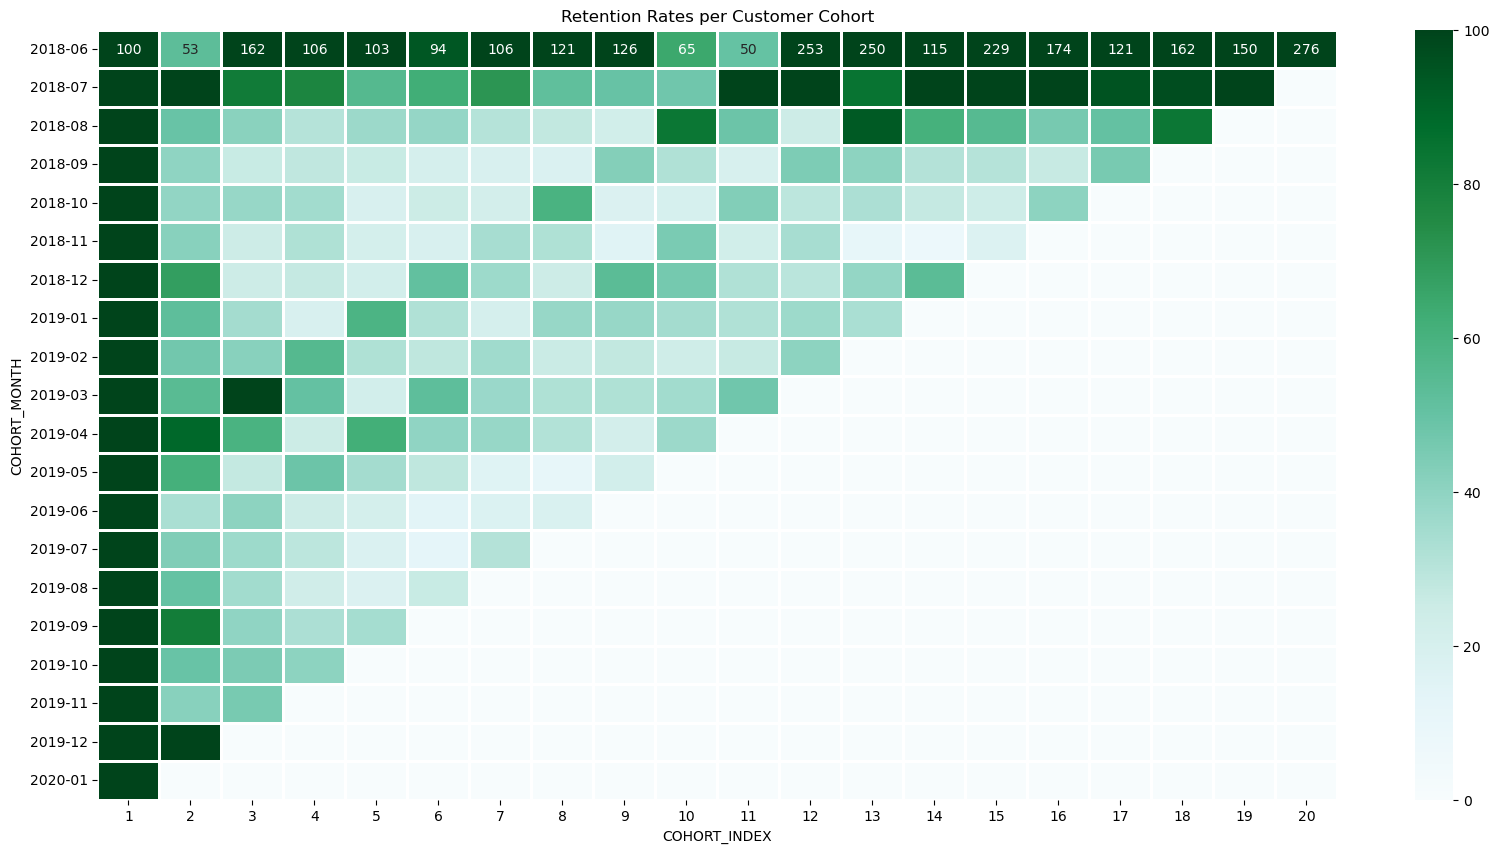

In [55]:
# Plot a heatmap of the retention rates
plt.figure(figsize=(20, 10))
plt.title('Retention Rates per Customer Cohort')
sns.heatmap(data=retention, 
            annot = True, 
            cmap = 'BuGn',
            fmt = '.0f',
            vmin=0,
            vmax=100,
            linewidths=1,
            )
plt.show()

In [ ]:
# Convert total points to int
df_agg['TOTAL_POINTS'] = df_agg['TOTAL_POINTS'].astype(int)

# Calculation of the absolute sum of negative values in the column TOTAL_POINTS for each CUSTOMER_ID
df_agg['POINTS_USED'] = df_agg['TOTAL_POINTS'].apply(lambda x: abs(x) if x < 0 else 0)

In [59]:
df_agg.head()

,CUSTOMER_ID,DATE,INVOICE_MONTH,COHORT_MONTH,CREATION_DATE,LONGEVITY,QUANTITY,TOTAL_POINTS,LIST_PRICE,SPECIAL,COHORT_INDEX,POINTS_USED
0,AA00312188,2018-09-27,2018-09-01,2018-07-01,2005-11-05,5171,123.0,18690,830.75,0,3,0
1,AA00312390,2019-05-04,2019-05-01,2018-07-01,2009-01-17,4025,78.0,4670,467.65,0,11,0
2,AA00325975,2019-05-04,2019-05-01,2018-06-01,2005-01-04,5499,209.0,-20085,1354.00,0,12,20085
3,AA00336843,2019-02-07,2019-02-01,2018-08-01,2014-03-12,2132,71.0,-13875,467.50,0,7,13875
4,AA00339761,2019-02-15,2019-02-01,2018-07-01,2004-02-13,5803,67.0,8130,484.90,0,8,0


In [62]:
# Processing of loyalty points
# Definition of the metric: 1 L is equivalent to 100 POINTS_USED
df_agg['L'] = df_agg['POINTS_USED']/100
df_agg['L'] = df_agg['L'].astype(int)

df_agg.head()

,CUSTOMER_ID,DATE,INVOICE_MONTH,COHORT_MONTH,CREATION_DATE,LONGEVITY,QUANTITY,TOTAL_POINTS,LIST_PRICE,SPECIAL,COHORT_INDEX,POINTS_USED,L
0,AA00312188,2018-09-27,2018-09-01,2018-07-01,2005-11-05,5171,123.0,18690,830.75,0,3,0,0
1,AA00312390,2019-05-04,2019-05-01,2018-07-01,2009-01-17,4025,78.0,4670,467.65,0,11,0,0
2,AA00325975,2019-05-04,2019-05-01,2018-06-01,2005-01-04,5499,209.0,-20085,1354.00,0,12,20085,200
3,AA00336843,2019-02-07,2019-02-01,2018-08-01,2014-03-12,2132,71.0,-13875,467.50,0,7,13875,138
4,AA00339761,2019-02-15,2019-02-01,2018-07-01,2004-02-13,5803,67.0,8130,484.90,0,8,0,0


In [64]:
# Refactor of transaction type and transaction value calculation
df_agg['TRANSACTION_VALUE'] = df_agg['LIST_PRICE'] * df_agg['QUANTITY']
# Set TRANSACTION_VALUE to float
df_agg['TRANSACTION_VALUE'] = df_agg['TRANSACTION_VALUE'].astype(float)
df_agg.head()

,CUSTOMER_ID,DATE,INVOICE_MONTH,COHORT_MONTH,CREATION_DATE,LONGEVITY,QUANTITY,TOTAL_POINTS,LIST_PRICE,SPECIAL,COHORT_INDEX,POINTS_USED,L,TRANSACTION_VALUE
0,AA00312188,2018-09-27,2018-09-01,2018-07-01,2005-11-05,5171,123.0,18690,830.75,0,3,0,0,102182.25
1,AA00312390,2019-05-04,2019-05-01,2018-07-01,2009-01-17,4025,78.0,4670,467.65,0,11,0,0,36476.70
2,AA00325975,2019-05-04,2019-05-01,2018-06-01,2005-01-04,5499,209.0,-20085,1354.00,0,12,20085,200,282986.00
3,AA00336843,2019-02-07,2019-02-01,2018-08-01,2014-03-12,2132,71.0,-13875,467.50,0,7,13875,138,33192.50
4,AA00339761,2019-02-15,2019-02-01,2018-07-01,2004-02-13,5803,67.0,8130,484.90,0,8,0,0,32488.30


In [65]:
# Determination of day of the week with the highest transaction value order by the day of the week
# Determination of the hour of the day with the highest transaction value
# Determine the ORIGIN_ with the highest transaction value
# Determine the region with the highest transaction value

In [67]:
snapshot_date = df_agg['DATE'].max() + pd.DateOffset(days=1)

In [87]:
# Determining Recency - Lower the value, the better (Obtained from aggregated dataframe - df_agg)
recency_datamart = df_agg.groupby('CUSTOMER_ID').agg({'DATE': lambda x: (snapshot_date - x.max()).days}).reset_index()

# Determining Frequency - Higher the value, the better (Obtained from original dataframe - df)
frequency_datamart = df.groupby('CUSTOMER_ID').agg({'DATE': 'count'}).reset_index()

# Determining Monetary - Higher the value, the better (Obtained from aggregated dataframe - df_agg)
monetary_datamart = df_agg.groupby('CUSTOMER_ID').agg({'TRANSACTION_VALUE': 'sum'}).reset_index().round(2)

# Merge the recency, frequency, and monetary dataframes
rfm_datamart = recency_datamart.merge(frequency_datamart, on = 'CUSTOMER_ID')
rfm_datamart = rfm_datamart.merge(monetary_datamart, on = 'CUSTOMER_ID')

# Rename the columns
rfm_datamart.columns = ['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary']

RFM = rfm_datamart
RFM.head()

,CUSTOMER_ID,Recency,Frequency,Monetary
0,AA00312188,487,102,102182.25
1,AA00312390,268,58,36476.70
2,AA00325975,268,205,282986.00
3,AA00336843,354,69,33192.50
4,AA00339761,346,59,32488.30


In [88]:
# Add the L column to the RFM dataframe (Loyalty Score)
RFM = RFM.merge(df_agg[['CUSTOMER_ID', 'L']], on = 'CUSTOMER_ID')
RFM.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L
0,AA00312188,487,102,102182.25,0
1,AA00312390,268,58,36476.70,0
2,AA00325975,268,205,282986.00,200
3,AA00336843,354,69,33192.50,138
4,AA00339761,346,59,32488.30,0


In [89]:
RFM.columns

Index(['CUSTOMER_ID', 'Recency', 'Frequency', 'Monetary', 'L'], dtype='object')

In [90]:
# Recency quartile
r_labels = range(4, 0, -1)
r_quartiles = pd.qcut(RFM['Recency'], 4, labels = r_labels)
RFM = RFM.assign(R = r_quartiles.values)

# Frequency quartile
f_labels = range(1, 5)
f_quartiles = pd.qcut(RFM['Frequency'], 4, labels = f_labels)
RFM = RFM.assign(F = f_quartiles.values)

# Monetary quartile
m_labels = range(1, 5)
RFM['Monetary'] = pd.to_numeric(RFM['Monetary'], errors='coerce')
m_quartiles = pd.qcut(RFM['Monetary'], 4, labels = m_labels)
RFM = RFM.assign(M = m_quartiles.values)

RFM.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,R,F,M
0,AA00312188,487,102,102182.25,0,1,3,4
1,AA00312390,268,58,36476.70,0,2,2,3
2,AA00325975,268,205,282986.00,200,2,4,4
3,AA00336843,354,69,33192.50,138,2,3,3
4,AA00339761,346,59,32488.30,0,2,2,3


In [91]:
def merge_rfm(x): return str(x['R']) + str(x['F']) + str(x['M'])
RFM['RFM_Segment'] = RFM.apply(merge_rfm, axis=1)
RFM['RFM_Score'] = RFM[['R', 'F', 'M']].sum(axis = 1)

RFM.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,R,F,M,RFM_Segment,RFM_Score
0,AA00312188,487,102,102182.25,0,1,3,4,134,8
1,AA00312390,268,58,36476.70,0,2,2,3,223,7
2,AA00325975,268,205,282986.00,200,2,4,4,244,10
3,AA00336843,354,69,33192.50,138,2,3,3,233,8
4,AA00339761,346,59,32488.30,0,2,2,3,223,7


In [92]:
RFM.groupby('RFM_Score').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

Recency Frequency  Monetary      
             mean      mean      mean count
RFM_Score                                  
3           474.1      18.5    3336.4  1152
4           296.1      21.0    4059.7  1682
5           295.7      30.9    9849.6  3301
6           173.4      32.3   11468.4  3757
7           300.5      61.8   37329.1  3211
8           181.8      66.6   44516.4  3084
9           299.9     126.8  205143.9  3375
10          157.7     130.6  211112.5  3084
11          136.2     170.1  328236.7  1729
12           40.6     177.0  335832.7  1352

In [93]:
# Add the segment labels as Gold, Silver, Bronze based on the RFM_Score as segment_me
def segment_me(df):
    if df['RFM_Score'] >= 9:
        return 'Gold'
    elif (df['RFM_Score'] >= 5) and (df['RFM_Score'] < 9):
        return 'Silver'
    else:
        return 'Bronze'
    
RFM['General_Segment'] = RFM.apply(segment_me, axis=1)
RFM.groupby('General_Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']
}).round(1)

Recency Frequency  Monetary       
                   mean      mean      mean  count
General_Segment                                   
Bronze            368.5      20.0    3765.7   2834
Gold              187.5     143.0  247903.4   9540
Silver            236.2      47.0   24919.7  13353

In [94]:
# Check the unique value of the RFM_Segment
RFM['RFM_Segment'].unique()

array(['134', '223', '244', '233', '123', '344', '444', '144', '222',
       '122', '434', '422', '334', '111', '333', '133', '433', '211',
       '311', '322', '411', '312', '323', '143', '423', '332', '132',
       '112', '421', '343', '243', '221', '212', '432', '234', '121',
       '443', '412', '321', '232', '213', '324', '424', '313', '113',
       '124', '224', '413'], dtype=object)

In [95]:
# Review the RFM_ dataframe
RFM.head()

,CUSTOMER_ID,Recency,Frequency,Monetary,L,R,F,M,RFM_Segment,RFM_Score,General_Segment
0,AA00312188,487,102,102182.25,0,1,3,4,134,8,Silver
1,AA00312390,268,58,36476.70,0,2,2,3,223,7,Silver
2,AA00325975,268,205,282986.00,200,2,4,4,244,10,Gold
3,AA00336843,354,69,33192.50,138,2,3,3,233,8,Silver
4,AA00339761,346,59,32488.30,0,2,2,3,223,7,Silver


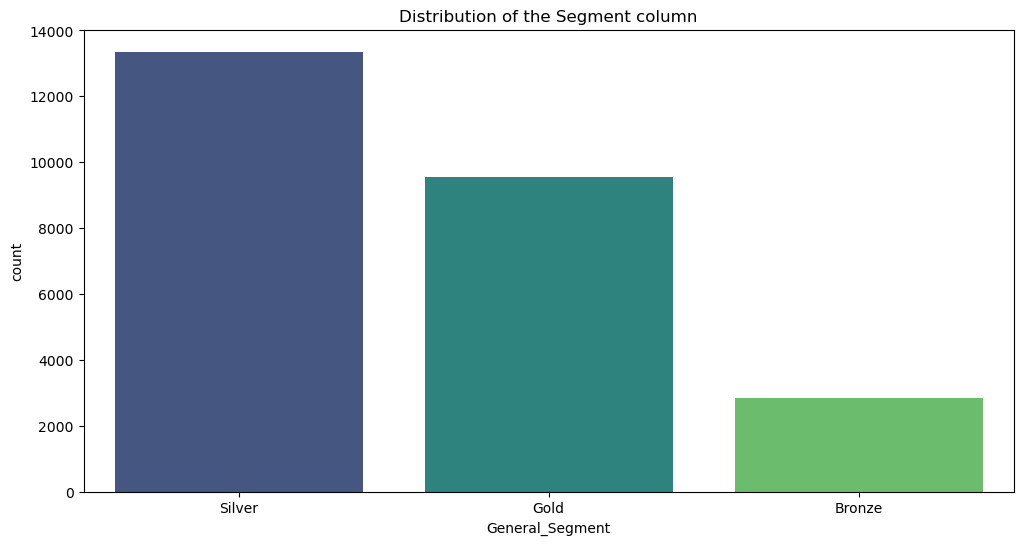

In [96]:
# Plot the distribution of the General_Segment column
plt.figure(figsize=(12, 6))
sns.countplot(data=RFM, x='General_Segment', palette='viridis')
plt.title('Distribution of the Segment column')
plt.show()

In [97]:
# Create new csv file from RFM_Final
RFM.to_csv('./datasets/1_SEGMENTATION/RFM_Label.csv', index=False)
# Drop the General_Segment column from the RFM dataframe and save it as a new csv file
RFM_ = RFM.copy()
RFM_.drop('General_Segment', axis=1, inplace=True)
RFM_.to_csv('./datasets/1_SEGMENTATION/RFM_Final.csv', index=False)